In [1]:
!pip install yfinance --upgrade --no-cache-dir

In [2]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os


import math
import yfinance as yf

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Get Stock Price, S&P Index, Nasdaq Index price from Yahoo Finance

In [4]:
df_stock = web.DataReader('^NYA', 'yahoo', start='2012-01-01', end='2022-03-29')

df_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,7659.970215,7459.450195,7477.029785,7624.319824,3943710000,7624.319824
2012-01-04,7624.319824,7559.990234,7624.319824,7612.149902,3592580000,7612.149902
2012-01-05,7613.600098,7512.649902,7612.149902,7599.970215,4315950000,7599.970215
2012-01-06,7601.479980,7535.620117,7599.970215,7557.680176,3656830000,7557.680176
2012-01-09,7588.890137,7539.339844,7557.680176,7584.660156,3371600000,7584.660156
...,...,...,...,...,...,...
2022-03-23,16735.480469,16557.580078,16735.480469,16558.529297,4014360000,16558.529297
2022-03-24,16702.230469,16558.529297,16558.529297,16701.820312,3573430000,16701.820312
2022-03-25,16794.179688,16669.789062,16701.820312,16792.800781,3577520000,16792.800781


Text(0, 0.5, 'Stock Price ($)')

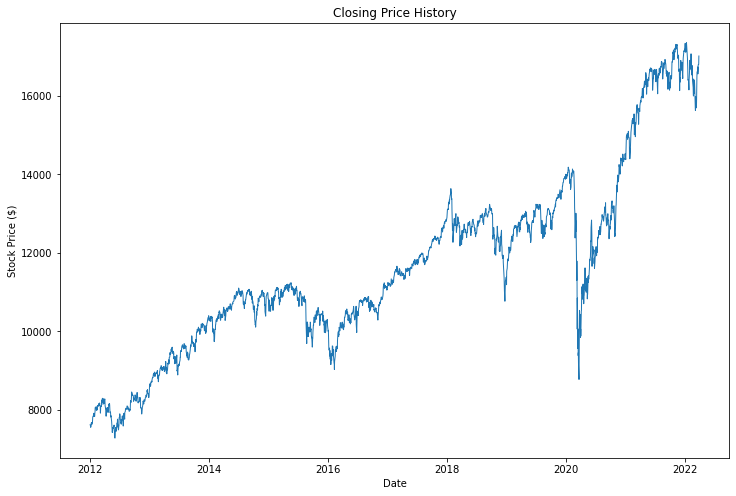

In [5]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_stock['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [6]:
df_snp = web.DataReader('^GSPC', 'yahoo', start='2012-01-01', end='2022-03-29')

df_snp

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1284.619995,1258.859985,1258.859985,1277.060059,3943710000,1277.060059
2012-01-04,1278.729980,1268.099976,1277.030029,1277.300049,3592580000,1277.300049
2012-01-05,1283.050049,1265.260010,1277.300049,1281.060059,4315950000,1281.060059
2012-01-06,1281.839966,1273.339966,1280.930054,1277.810059,3656830000,1277.810059
2012-01-09,1281.989990,1274.550049,1277.829956,1280.699951,3371600000,1280.699951
...,...,...,...,...,...,...
2022-03-23,4501.069824,4455.810059,4493.100098,4456.240234,4014360000,4456.240234
2022-03-24,4520.580078,4465.169922,4469.979980,4520.160156,3573430000,4520.160156
2022-03-25,4546.029785,4501.069824,4522.910156,4543.060059,3577520000,4543.060059


Text(0, 0.5, 'Stock Price ($)')

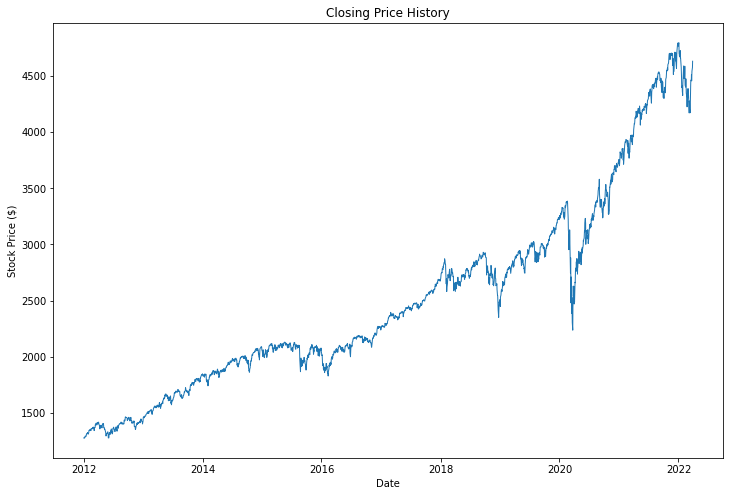

In [7]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_snp['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [8]:
df_nasdaq = web.DataReader('^IXIC', 'yahoo', start='2012-01-01', end='2022-03-29')

df_nasdaq

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,2665.899902,2641.979980,2657.389893,2648.719971,1636850000,2648.719971
2012-01-04,2653.179932,2627.229980,2639.899902,2648.360107,1670530000,2648.360107
2012-01-05,2673.560059,2631.229980,2642.570068,2669.860107,1836410000,2669.860107
2012-01-06,2682.120117,2658.830078,2671.169922,2674.219971,1683090000,2674.219971
2012-01-09,2683.780029,2662.959961,2682.979980,2676.560059,1768080000,2676.560059
...,...,...,...,...,...,...
2022-03-23,14152.139648,13921.650391,13990.349609,13922.599609,4995470000,13922.599609
2022-03-24,14193.549805,13897.200195,14001.320312,14191.839844,5046250000,14191.839844
2022-03-25,14218.759766,14010.790039,14194.719727,14169.299805,5553860000,14169.299805


Text(0, 0.5, 'Stock Price ($)')

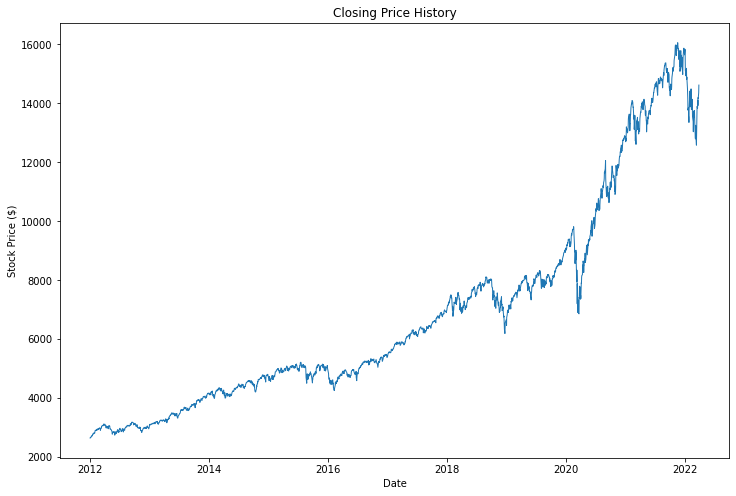

In [9]:
plt.figure(figsize=(12,8))
plt.title('Closing Price History')
plt.plot(df_nasdaq['Close'], lw=1)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

In [10]:
df = df_stock.filter(['Close'])
df['Close_Stock'] = df_stock.filter(['Close'])
df = df.drop('Close', axis=1)
df['CLose_S&P'] = df_snp.filter(['Close'])
df['CLose_Nasdaq'] = df_nasdaq.filter(['Close'])
df

,Close_Stock,CLose_S&P,CLose_Nasdaq
Date,,,
2012-01-03,7624.319824,1277.060059,2648.719971
2012-01-04,7612.149902,1277.300049,2648.360107
2012-01-05,7599.970215,1281.060059,2669.860107
2012-01-06,7557.680176,1277.810059,2674.219971
2012-01-09,7584.660156,1280.699951,2676.560059
...,...,...,...
2022-03-23,16558.529297,4456.240234,13922.599609
2022-03-24,16701.820312,4520.160156,14191.839844
2022-03-25,16792.800781,4543.060059,14169.299805


In [11]:
df.shape[0]

2577

Transform the Data

In [12]:
X0=[]
X1=[]
X2=[]
y=[]

look_back = 60

for i in range (0, df.shape[0]-look_back):
    X0.append(df.iloc[i:i + look_back, 0])
    X1.append(df.iloc[i:i + look_back, 1])
    X2.append(df.iloc[i:i + look_back, 2])
    y.append(df.iloc[i + look_back, 0])


In [13]:
type(X2)

list

In [14]:
df.head(5)

,Close_Stock,CLose_S&P,CLose_Nasdaq
Date,,,
2012-01-03,7624.319824,1277.060059,2648.719971
2012-01-04,7612.149902,1277.300049,2648.360107
2012-01-05,7599.970215,1281.060059,2669.860107
2012-01-06,7557.680176,1277.810059,2674.219971
2012-01-09,7584.660156,1280.699951,2676.560059


In [15]:
df.tail(5)

,Close_Stock,CLose_S&P,CLose_Nasdaq
Date,,,
2022-03-23,16558.529297,4456.240234,13922.599609
2022-03-24,16701.820312,4520.160156,14191.839844
2022-03-25,16792.800781,4543.060059,14169.299805
2022-03-28,16798.720703,4575.520020,14354.900391
2022-03-29,17014.759766,4631.600098,14619.639648


In [16]:
X0, X1, X2, y = np.array(X0), np.array(X1), np.array(X2), np.array(y)

In [17]:
X1.shape

(2517, 60)

In [18]:
y.shape

(2517,)

In [19]:
y=np.reshape(y,(len(y),-1))

In [20]:
y.shape

(2517, 1)

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
X0 = scaler.fit_transform(X0)
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
y = scaler.fit_transform(y)

In [22]:
X=np.stack((X0,X1,X2), axis=2)
X

array([[[3.37945851e-02, 0.00000000e+00, 2.68372828e-05],
        [3.25806254e-02, 0.00000000e+00, 0.00000000e+00],
        [3.12837762e-02, 9.23623446e-04, 0.00000000e+00],
        ...,
        [9.96451700e-02, 3.93546065e-02, 2.81811572e-02],
        [9.47336617e-02, 3.82206097e-02, 2.80143670e-02],
        [8.96702116e-02, 3.62368266e-02, 2.68580798e-02]],

       [[3.25806254e-02, 6.82566082e-05, 0.00000000e+00],
        [3.13656915e-02, 1.06840920e-03, 1.60339110e-03],
        [2.70763271e-02, 0.00000000e+00, 3.25664771e-04],
        ...,
        [9.47336617e-02, 3.82206097e-02, 2.80143670e-02],
        [8.96702116e-02, 3.62368266e-02, 2.68580798e-02],
        [8.74871088e-02, 3.55945084e-02, 2.61368265e-02]],

       [[3.13656915e-02, 1.13765643e-03, 1.60339110e-03],
        [2.71472253e-02, 1.44919604e-04, 1.92853370e-03],
        [2.97605737e-02, 8.21283859e-04, 5.00460203e-04],
        ...,
        [8.96702116e-02, 3.62368266e-02, 2.68580798e-02],
        [8.74871088e-02, 3.55

In [23]:
X.shape

(2517, 60, 3)

In [24]:
X_train, X_test = X[:-514], X[-514:]
y_train, y_test = y[:-514], y[-514:]
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(2003, 60, 3)

In [25]:
model = Sequential()
# set return requesnce = true, if we are going to have another LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [27]:
filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

In [28]:
optimizers.SGD(momentum=0.9)
model.compile(optimizer='SGD', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=callbacks, batch_size=16)

Epoch 1/10
101/101 [==============================] - 21s 124ms/step - loss: 0.0200 - mae: 0.1094 - val_loss: 0.0285 - val_mae: 0.1604
Epoch 2/10
101/101 [==============================] - 9s 93ms/step - loss: 0.0081 - mae: 0.0702 - val_loss: 0.0208 - val_mae: 0.1358
Epoch 3/10
101/101 [==============================] - 7s 65ms/step - loss: 0.0061 - mae: 0.0612 - val_loss: 0.0133 - val_mae: 0.1067
Epoch 4/10
101/101 [==============================] - 6s 55ms/step - loss: 0.0045 - mae: 0.0521 - val_loss: 0.0090 - val_mae: 0.0859
Epoch 5/10
101/101 [==============================] - 5s 54ms/step - loss: 0.0031 - mae: 0.0434 - val_loss: 0.0060 - val_mae: 0.0678
Epoch 6/10
101/101 [==============================] - 8s 75ms/step - loss: 0.0020 - mae: 0.0353 - val_loss: 0.0043 - val_mae: 0.0551
Epoch 7/10
101/101 [==============================] - 6s 55ms/step - loss: 0.0013 - mae: 0.0286 - val_loss: 0.0028 - val_mae: 0.0407
Epoch 8/10
101/101 [==============================] - 6s 55ms/step 

In [29]:
MSE, MAE = model.evaluate(X_test, y_test)
print(MSE, MAE)

17/17 [==============================] - 0s 17ms/step - loss: 0.0229 - mae: 0.1322
0.022932585328817368 0.13218186795711517


In [30]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions

array([[12783.199 ],
       [12677.276 ],
       [12557.086 ],
       [12430.873 ],
       [12297.233 ],
       [12142.292 ],
       [11998.629 ],
       [11872.51  ],
       [11777.666 ],
       [11700.279 ],
       [11642.158 ],
       [11595.725 ],
       [11551.113 ],
       [11513.055 ],
       [11477.048 ],
       [11456.811 ],
       [11448.934 ],
       [11455.552 ],
       [11475.785 ],
       [11504.034 ],
       [11541.89  ],
       [11579.516 ],
       [11616.368 ],
       [11656.727 ],
       [11694.687 ],
       [11727.407 ],
       [11758.539 ],
       [11787.929 ],
       [11817.005 ],
       [11848.527 ],
       [11881.519 ],
       [11919.54  ],
       [11957.7705],
       [11990.617 ],
       [12018.875 ],
       [12044.332 ],
       [12065.667 ],
       [12085.229 ],
       [12106.073 ],
       [12125.004 ],
       [12140.939 ],
       [12151.486 ],
       [12158.64  ],
       [12163.523 ],
       [12171.676 ],
       [12180.985 ],
       [12193.239 ],
       [12206

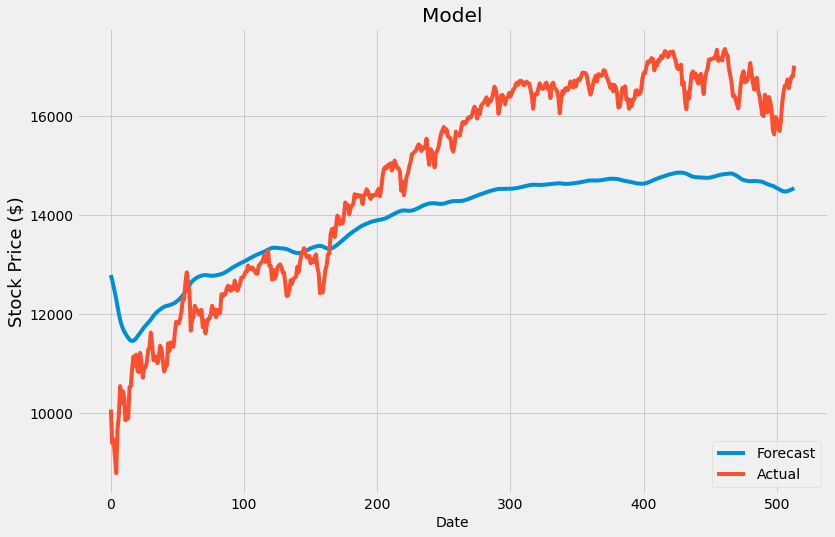

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Stock Price ($)', fontsize=18)
plt.plot(predictions)
plt.plot(scaler.inverse_transform(y_test))
plt.legend(['Forecast', 'Actual'],loc='lower right')
plt.show()

In [32]:
predicted_prce_df = pd.DataFrame(predictions, columns=['Predicted Price'])
predicted_prce_df = predicted_prce_df[-5:]
predicted_prce_df

,Predicted Price
509,14488.706055
510,14499.264648
511,14511.499023
512,14525.245117
513,14539.862305


In [33]:
#get the quote
actual_price = web.DataReader('^NYA', 'yahoo', '2022-03-23', '2022-03-29')
actual_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-03-23,16735.480469,16557.580078,16735.480469,16558.529297,4014360000,16558.529297
2022-03-24,16702.230469,16558.529297,16558.529297,16701.820312,3573430000,16701.820312
2022-03-25,16794.179688,16669.789062,16701.820312,16792.800781,3577520000,16792.800781
2022-03-28,16798.720703,16640.140625,16792.800781,16798.720703,3696850000,16798.720703
2022-03-29,17034.910156,16798.720703,16798.720703,17014.759766,4239660000,17014.759766


In [34]:
price_diff = actual_price.filter(['Close'])
price_diff["Predicted Price"] = pd.NaT
price_diff["Predicted Price"] = np.array(predicted_prce_df)
price_diff["Price Difference"] = pd.NaT
price_diff["Price Difference"] = price_diff["Predicted Price"] - price_diff["Close"]

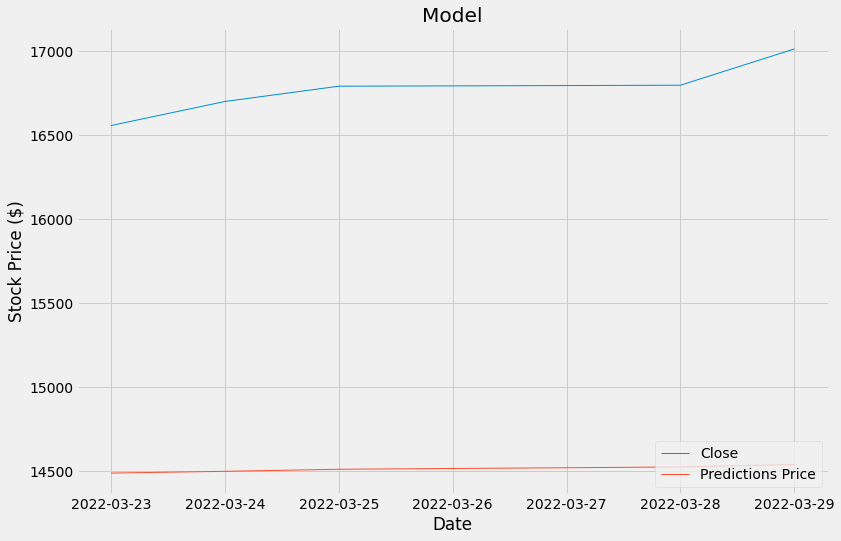

In [35]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(price_diff[['Close','Predicted Price']], lw=1)
plt.legend(['Close','Predictions Price'],loc='lower right')
plt.show()

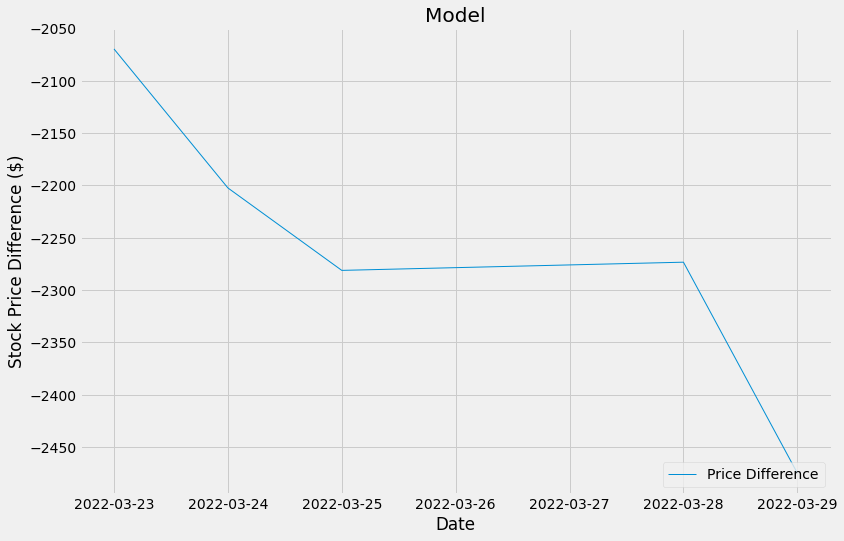

In [36]:
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price Difference ($)')
plt.plot(price_diff[['Price Difference']], lw=1)
plt.legend(['Price Difference'],loc='lower right')
plt.show()

In [37]:
price_diff["Price Diff Percentage"] = pd.NaT
price_diff["Price Diff Percentage"] = (price_diff["Price Difference"] * 100) / price_diff["Close"]
price_diff["Buy/Sell Stock"] = pd.NaT
price_diff["Cost"] = pd.NaT
price_diff

,Close,Predicted Price,Price Difference,Price Diff Percentage,Buy/Sell Stock,Cost
Date,,,,,,
2022-03-23,16558.529297,14488.706055,-2069.823242,-12.500043,NaT,NaT
2022-03-24,16701.820312,14499.264648,-2202.555664,-13.187519,NaT,NaT
2022-03-25,16792.800781,14511.499023,-2281.301758,-13.584999,NaT,NaT
2022-03-28,16798.720703,14525.245117,-2273.475586,-13.533623,NaT,NaT
2022-03-29,17014.759766,14539.862305,-2474.897461,-14.545592,NaT,NaT


Key assumptions:

*   Threshold set at 2% of fluctuation
*   Only one strategy (e.g. buy or sell) will be exercise at one time. We  will not long and short the same stock at the same time for the 5 days period
*   We will close out the position (e.g. to sell all holdings for the case of long, and to buy back the number of required shares for the case of short) using the actual price on the fifth day

In [42]:
threshold = -2.0
num_stock = 0.0
for index, row in price_diff.iterrows():
  if row["Price Diff Percentage"] > threshold:
    price_diff.at[index, ["Cost"]] = row['Close']
    price_diff.at[index, ["Buy/Sell Stock"]] = 'No Action'
    num_stock = num_stock + 1
  elif row["Price Diff Percentage"] < threshold:
    price_diff.at[index, ["Cost"]] = row['Close']
    price_diff.at[index, ["Buy/Sell Stock"]] = 'Sell'
    num_stock = num_stock + 1
price_diff

,Close,Predicted Price,Price Difference,Price Diff Percentage,Buy/Sell Stock,Cost
Date,,,,,,
2022-03-23,16558.529297,14488.706055,-2069.823242,-12.500043,Sell,16558.529297
2022-03-24,16701.820312,14499.264648,-2202.555664,-13.187519,Sell,16701.820312
2022-03-25,16792.800781,14511.499023,-2281.301758,-13.584999,Sell,16792.800781
2022-03-28,16798.720703,14525.245117,-2273.475586,-13.533623,Sell,16798.720703
2022-03-29,17014.759766,14539.862305,-2474.897461,-14.545592,Sell,17014.759766


In [44]:
print("Number of stocks sold : ",num_stock)
total_cost = price_diff['Cost'].sum()
print("Total Cost : ", total_cost)
p_n_l = (price_diff['Close'][4])*num_stock - total_cost
print("Profit or Loss : ", p_n_l)
p_n_l_per = (p_n_l*100)/total_cost
print("Profit or Loss percentage : ", p_n_l_per)

Number of stocks sold :  5.0
Total Cost :  83866.630859375
Profit or Loss :  1207.16796875
Profit or Loss percentage :  1.4393900844474632
